In [1]:
import pandas as pd

In [5]:
data_df = pd.read_json("CMeEE_train.json")

In [132]:
processed_data = []
for item in data_df.itertuples():
    row_data_dict = dict()
    # insert space between every two chars
    row_data_dict["text_a"] = " ".join(list("".join((item.text.split()))))

    # generate sentence label
    label_sent = ["O"] * (len(item.text))
    region_dict = dict()

    for entity in item.entities:
        start = entity["start_idx"]
        end = entity["end_idx"]

        if start == end:
            label_sent[start] = "S"
            region_dict[(start, end)] = entity["type"]
            continue

        if label_sent[start] == "E" or label_sent[end] == "B":
            print(item, "boundary redandency")
        else:
            label_sent[start] = "B" if label_sent[start] != "S" else "S"
            label_sent[end] = "E" if label_sent[end] != "S" else "S"

            region_dict[(start, end)] = entity["type"]

            for ele_idx, elem_label in enumerate(label_sent[start + 1:end]):
                if elem_label == "O":
                    label_sent[ele_idx + start + 1] = "M"

    row_data_dict["bd_label"] = " ".join(label_sent)

    # generate region label
    label_region = []
    for start_idx, head in enumerate(label_sent):
        if head == "S" or head == "B":
            # single entity
            if head == "S":
                label_region.append(region_dict[(start_idx, start_idx)])

            # other entity
            for end_idx, tail in enumerate(label_sent[start_idx + 1:]):
                if tail == "S" or tail == "E":
                    tail_idx = start_idx + 1 + end_idx
                    label = region_dict[(start_idx, tail_idx)] if ((start_idx, tail_idx) in region_dict) else "O"
                    label_region.append(label)

                elif tail == "O":
                    break

    row_data_dict["entity_label"] = " ".join(label_region)

    processed_data.append(row_data_dict)

Pandas(Index=9348, text='未用呼吸机的患儿可表现为三凹征，腹部肝脏肿大。', entities=[{'start_idx': 2, 'end_idx': 4, 'type': 'equ', 'entity': '呼吸机'}, {'start_idx': 12, 'end_idx': 14, 'type': 'dis', 'entity': '三凹征'}, {'start_idx': 16, 'end_idx': 16, 'type': 'ite', 'entity': '腹'}, {'start_idx': 16, 'end_idx': 16, 'type': 'bod', 'entity': '腹'}, {'start_idx': 14, 'end_idx': 17, 'type': 'sym', 'entity': '征，腹部'}]) boundary redandency


In [133]:
len(processed_data)

15000

In [136]:
processed_data_df = pd.DataFrame(data=processed_data, columns=["text_a", "bd_label", "entity_label"])

In [137]:
processed_data_df.to_csv("train.tsv", sep="\t")

<AxesSubplot:ylabel='Frequency'>

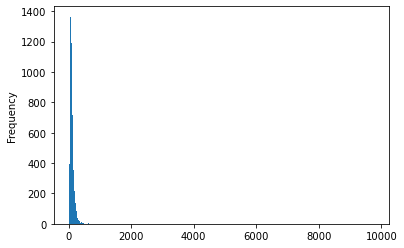

In [146]:
processed_data_df.text_a.apply(lambda x: len(x)).plot.hist(bins=1000)

In [272]:
def _split_long_sent(query_data: list, max_seq_len=128, ratio_slide=1):
    """
    This function is for split the sentence which length over 128
    :param query_data: list of string
    :return: processed_query_data: list of string, length of each string smaller than 128
             concate_data_dict: map of raw text to splitted data
    """
    processed_query_data = []
    processed_seq_idx = []

    query_len = len(query_data)
    concate_data_dict = dict(zip(range(query_len), [[] for _ in range(query_len)]))

    for idx_sent, sent in enumerate(query_data):
        sent_len = len(str(sent))
        if sent_len > max_seq_len:  # parse the sentence if length larger than max len
            split_pos = 0
            while sent_len - split_pos > max_seq_len:  # if the rest part shorter than max seq_len, break
                is_split = False  # flag, if sentence does not contain any split symbol will be directly appended
                cur_head = split_pos + max_seq_len - 1
                for idx, char in enumerate(sent[cur_head:split_pos:-1]):
                    if char in [",", ".", ";", "，", "。", "；"]:
                        processed_query_data.append(sent[split_pos:cur_head - idx + 1])
                        processed_seq_idx.append([split_pos, cur_head - idx])

                        split_pos += max_seq_len - idx
                        concate_data_dict[idx_sent].append(len(processed_query_data) - 1)
                        is_split = True
                        break

                if not is_split:  # full sent added into list
                    print(query_data)
                    processed_query_data.append(sent[split_pos:split_pos + max_seq_len])
                    processed_seq_idx.append([split_pos, split_pos + max_seq_len - 1])

                    concate_data_dict[idx_sent].append(len(processed_query_data) - 1)
                    split_pos += max_seq_len

                slide_pos = int(split_pos - (1 - ratio_slide) * len(processed_query_data[-1]))
                for idx, char in enumerate(sent[slide_pos:split_pos]):
                    if char in [",", ".", ";", "，", "。", "；"]:
                        split_pos = idx + slide_pos + 1
                        break

            processed_query_data.append(sent[split_pos:])
            processed_seq_idx.append([split_pos, sent_len - 1])

        else:
            processed_query_data.append(sent)
            processed_seq_idx.append([0, sent_len - 1])

        concate_data_dict[idx_sent].append(len(processed_query_data) - 1)  # record the last span or short sentence

    return processed_query_data, concate_data_dict, processed_seq_idx

In [273]:
new_data=list()
for item in data_df.itertuples():
    region_dict = dict()
    entity_list = list()

    for entity in item.entities:
        start = entity["start_idx"]
        end = entity["end_idx"]
        region_dict[(start, end)] = {"type": entity["type"], "entity": entity["entity"]}

    seq_list, seq_dict, seq_idx_list = _split_long_sent([item.text], ratio_slide=0.5)


    for seq, seq_idx in zip(seq_list, seq_idx_list):
        seq_len = len(seq)
        sub_seq_region_list = list()
        for (start, end), entity in region_dict.items():
            if end < seq_idx[1] and start > seq_idx[0]:
                sub_seq_entity = {"start_idx": start - seq_idx[0], "end_idx": end - seq_idx[0], "type": entity["type"],
                                  "entity": entity["entity"]}
                sub_seq_region_list.append(sub_seq_entity)

                if entity["entity"] != seq[sub_seq_entity["start_idx"]:sub_seq_entity["end_idx"] + 1]:
                    print("error")

        new_data.append({"text":seq,"entities":sub_seq_region_list})


['对先天性肾畸形，如蹄铁形肾（horseshoekidney）、孤立肾（singlekidney）、双肾一侧融合（unilateralfusion）、重复肾（duplicationofthekidney）和先天性肾盂输尿管连接部狭窄（pelviuretericobstruction）等，本法可一目了然，并可了解局部的功能状态。']
['相对来说比较常用的手术方法有尿道口前移龟头成形术（meata尿道口前移龟头成形术ndgmeataladvancementandglanuloplastyincorporatedprocedure或FMAGPIFlapMathieu，Filp-Flap尿道成形术la加盖岛状皮瓣尿道成形术成形onlayislandflap尿道成形术皮内板横行岛状皮瓣尿道成形术包皮内板横行岛状皮瓣尿道成形术十年Duckett术多的在无阴茎下弯的尿道下裂中应用尿道板纵切卷管尿道成形术（也尿道板纵切卷管尿道成形术。']
['一、免疫学检查（一）免疫活化现象免疫活化现象有关的实验室检查结果是引导临床诊断风湿性疾病的简易途径：1.血清免疫球蛋白（immunoglobulin，Ig）Ig水平升高是风湿性疾病最常见的免疫活化现象，系统性红斑狼疮（SLE）、幼年特发性关节炎（JIA）、皮肌炎以及各种血管炎综合征均常有一种或几种免疫球蛋白显著升高B细胞增殖及分泌功能过度活化淋巴细胞表型分析免疫活化现象还可以在淋巴细胞表型分析检测发现CD3、CD4、CD8、CD16、CD19、CD20阳性细胞绝对数与相对数增加得到证实。']
['其中朊病毒是1982年美国学者Prusiner首先报道的一种对核酸酶有抵抗性的感染性蛋白质，被称为朊蛋白（prion），是引起疯牛（羊）病和人类CJD及库鲁（Kuru）病等中枢神经系统慢感染（以前称为慢病毒感染）的致癌因子表16-9神经系统病毒感染的临床类型与疾病*</sup>由朊蛋白（prion）感染所致表16-10DNA病毒的分类【常见病毒所致神经系统感染的临床特点】不同病毒所致神经系统感染的临床特点有所差异（表16-16）。']
['①大肠杆菌（Escherichiacoli，E.Coli）：按其致病机制分类为致病性大肠杆菌（Entero-pathogenicE.Coli，EPEC）、产毒素性大肠杆菌（EnterotoxigenicE.Co

In [270]:
for item in pd.DataFrame(new_data).itertuples():
    for entity in item.entities:
        if item.text[entity["start_idx"]:entity["end_idx"]+1] != entity["entity"]:
            print("error")

In [274]:
new_data

[{'text': '（5）房室结消融和起搏器植入作为反复发作或难治性心房内折返性心动过速的替代疗法。',
  'entities': [{'start_idx': 3,
    'end_idx': 7,
    'type': 'pro',
    'entity': '房室结消融'},
   {'start_idx': 9, 'end_idx': 13, 'type': 'pro', 'entity': '起搏器植入'},
   {'start_idx': 16,
    'end_idx': 33,
    'type': 'dis',
    'entity': '反复发作或难治性心房内折返性心动过速'}]},
 {'text': '（6）发作一次伴血流动力学损害的室性心动过速（ventriculartachycardia），可接受导管消融者。',
  'entities': [{'start_idx': 8,
    'end_idx': 21,
    'type': 'dis',
    'entity': '血流动力学损害的室性心动过速'},
   {'start_idx': 23,
    'end_idx': 44,
    'type': 'dis',
    'entity': 'ventriculartachycardia'},
   {'start_idx': 50, 'end_idx': 53, 'type': 'pro', 'entity': '导管消融'}]},
 {'text': '4.第三类（1）无症状性WPW综合征患者，年龄小于5岁。',
  'entities': [{'start_idx': 8,
    'end_idx': 17,
    'type': 'dis',
    'entity': '无症状性WPW综合征'}]},
 {'text': '（2）室上性心动过速可用常规抗心律失常药物控制，年龄小于5岁。',
  'entities': [{'start_idx': 3,
    'end_idx': 9,
    'type': 'dis',
    'entity': '室上性心动过速'}]},
 {'text': '（3）非持续性，不考虑为无休止性的阵发性室性心动过速（即一次监视数小时或任何一小时记录的